# AutoRec for Rating Prediction

## Motivation

This notebook focuses on **rating prediction** (RMSE, MAE) for explicit feedback.

Unlike ranking metrics which measure top-K recommendation quality,
rating prediction measures how accurately we can predict the exact rating a user would give.

## Metrics

- **RMSE (Root Mean Squared Error)**: sqrt(mean((predicted - actual)²))
- **MAE (Mean Absolute Error)**: mean(|predicted - actual|)

Lower values indicate better performance for both metrics.


In [1]:
import os
import sys

current_dir = os.getcwd()

# Walk up the directory tree until we find 'src'
path = current_dir
src_path = None

while True:
    if os.path.basename(path) == "src":
        src_path = path
        break
    parent = os.path.dirname(path)
    if parent == path:  # reached filesystem root
        break
    path = parent

# Add src to sys.path if found
if src_path and src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import AutoRec model and data utilities
from utils.model import AutoRec
from utils.autorecdata import AutoRecData
from utils.preprocessor import PreProcessor
from helpers.data_downloader import download_ml1m_dataset
# Import external libraries
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
print("=" * 70)
print("Imports Successful")
print("=" * 70)

Imports Successful


/Users/abbas/Documents/Codes/thesis/recommender/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
data_path = os.path.join(data_dir,'ml-1m', 'ratings.dat')
print(data_path)
print(data_dir)
# Check if file exists
if not os.path.exists(data_path):
    download_ml1m_dataset(data_dir=data_dir)

def load_ml_1m_data(data_path = data_path) -> pd.DataFrame:  
    print("=" * 70)
    print("Loading MovieLens 1M Dataset")
    print("=" * 70)
    print(f"Data path: {data_path}")
    return pd.read_csv(
        data_path,
        sep='::',
        header=None,
        names=['user_id', 'item_id', 'rating', 'timestamp'],
        engine='python',  # Explicitly use python engine to avoid warning
        dtype={
            'user_id': np.int32,
            'item_id': np.int32,
            'rating': np.float32,
            'timestamp': np.int32
        }
    )


torch.manual_seed(42)
np.random.seed(42)
# Load ratings data with proper engine to avoid warnings
print("\nLoading ratings data...")

ratings_df = load_ml_1m_data()

print(f"✓ Successfully loaded {len(ratings_df):,} ratings")
print("=" * 70)

/Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
/Users/abbas/Documents/Codes/thesis/recommender/src/../data

Loading ratings data...
Loading MovieLens 1M Dataset
Data path: /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
✓ Successfully loaded 1,000,209 ratings


In [5]:
# Create PreProcessor instance
preprocessor = PreProcessor()

# Preprocess the data: split into train/test and create rating matrices
# Paper uses 90-10 split (test_size=0.1)
print("\nSplitting data into train/test sets and creating rating matrices...")
print("=" * 70)
train_mat, test_mat, num_users, num_items = preprocessor.preprocess_ml1m_data(
    ratings_df, 
    test_size=0.2,  # 10% for testing (90-10 split as per paper)
    random_state=42  # For reproducibility
)

print(f"✓ Data preprocessing complete!")
print(f"Train matrix shape: {train_mat.shape}, Test matrix shape: {test_mat.shape}")
print("=" * 70)


Splitting data into train/test sets and creating rating matrices...
✓ Data preprocessing complete!
Train matrix shape: (6040, 3706), Test matrix shape: (6040, 3706)


In [6]:
# Split training data into train and validation sets
# Paper mentions holding out 10% of training set for hyperparameter tuning
# We'll use 10% of training data for validation
from sklearn.model_selection import train_test_split

# Convert train_mat to list of (user, item, rating) tuples for splitting
train_ratings = []
for user in range(train_mat.shape[0]):
    for item in range(train_mat.shape[1]):
        if train_mat[user, item] > 0:
            train_ratings.append((user, item, train_mat[user, item]))

# Split into train and validation (90-10 split of training data)
train_ratings_split, val_ratings_split = train_test_split(
    train_ratings, test_size=0.2, random_state=42
)

# Create new train and validation matrices
train_mat_new = np.zeros_like(train_mat)
val_mat = np.zeros_like(train_mat)

for user, item, rating in train_ratings_split:
    train_mat_new[user, item] = rating

for user, item, rating in val_ratings_split:
    val_mat[user, item] = rating

# Create datasets for item-based AutoRec
# item_based=True means we iterate over item vectors (columns of rating matrix)
train_set = AutoRecData(data=train_mat_new, item_based=True)
val_set = AutoRecData(data=val_mat, item_based=True)
test_set = AutoRecData(data=test_mat, item_based=True)

print(f"Training set: {train_mat_new.shape}, {np.count_nonzero(train_mat_new):,} ratings")
print(f"Validation set: {val_mat.shape}, {np.count_nonzero(val_mat):,} ratings")
print(f"Test set: {test_mat.shape}, {np.count_nonzero(test_mat):,} ratings")
print("=" * 70)

Training set: (6040, 3706), 640,133 ratings
Validation set: (6040, 3706), 160,034 ratings
Test set: (6040, 3706), 200,042 ratings


In [7]:
train_loader = data.DataLoader(
    dataset=train_set,
    batch_size=256,
    shuffle=True,
    num_workers=0,
)
print('Train loader created')
print("=" * 70)
test_loader = data.DataLoader(
    dataset=test_set, batch_size=len(test_set), shuffle=False, num_workers=0
)
print('Test loader created')
print("=" * 70)

Train loader created
Test loader created


In [8]:
# Set device (CPU or CUDA if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create item-based AutoRec model (I-AutoRec)
# Paper uses k=500 hidden units
model = AutoRec(
    num_users=num_users,
    num_items=num_items,
    num_hidden_units=500,  # k=500 as per paper
    item_based=True,  # Item-based AutoRec (I-AutoRec)
).to(device)

# Initialize weights properly (Xavier/Glorot initialization for better convergence)
# This helps with training stability
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(init_weights)
print("Model initialized with Xavier uniform initialization")

Using device: cpu
Model initialized with Xavier uniform initialization


In [9]:
loss_f = nn.MSELoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0,  # Set to 0 since we'll add explicit L2 regularization
)


lambda_reg = 0.001  # Try 0.001, 0.01, or 0.1 to find best value

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping
min_delta = 0.0001  # Minimum change to qualify as an improvement
best_val_rmse = np.inf
best_epoch = 0
epochs_without_improvement = 0

# Model saving
import os
models_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
os.makedirs(models_dir, exist_ok=True)
best_model_path = os.path.join(models_dir, 'AutoRec-best.pth')

best_test_rmse = np.inf  # Track best test RMSE for summary cells

print(model)
print(f"Models will be saved to: {best_model_path}")
print(f"Early stopping: patience={patience}, min_delta={min_delta}")
print("=" * 70)

AutoRec(
  (encoder): Sequential(
    (0): Linear(in_features=6040, out_features=500, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=6040, bias=True)
  )
)
Models will be saved to: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
Early stopping: patience=10, min_delta=0.0001


## Step 8: Training Loop

Train AutoRec with MSE loss and L2 regularization for rating prediction.

In [10]:
from utils.helper import get_rating_metrics

# Lists to store metrics for visualization
train_losses = []
val_rmses = []
val_maes = []
test_rmses = []
test_maes = []

print("=" * 70)
print("Training AutoRec for Rating Prediction")
print("=" * 70)

for epoch in tqdm(range(50)):
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    for input_vec in train_loader:
        input_mask = (input_vec > 0).to(device)
        input_vec = input_vec.float().to(device)

        model.zero_grad()
        reconstruction = model(input_vec)
        
        # Reconstruction loss (only on observed ratings)
        squared_diff = (reconstruction - input_vec) ** 2
        masked_squared_diff = squared_diff * input_mask
        num_observed = input_mask.sum()
        if num_observed > 0:
            recon_loss = masked_squared_diff.sum() / num_observed
        else:
            recon_loss = torch.tensor(0.0, device=device)
        
        # L2 regularization
        l2_reg = 0.0
        l2_reg += torch.sum(model.encoder[0].weight ** 2)
        l2_reg += torch.sum(model.decoder[0].weight ** 2)
        
        # Total loss
        loss = recon_loss + (lambda_reg / 2.0) * l2_reg
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average training loss
    avg_train_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    train_losses.append(avg_train_loss)

    model.eval()
    
    # Evaluate on validation and test sets
    val_rmse, val_mae = get_rating_metrics(
        model=model, 
        train_set=train_set, 
        test_set=val_set, 
        device=device, 
        item_based=True
    )
    
    test_rmse, test_mae = get_rating_metrics(
        model=model, 
        train_set=train_set, 
        test_set=test_set, 
        device=device, 
        item_based=True
    )
    
    val_rmses.append(val_rmse)
    val_maes.append(val_mae)
    test_rmses.append(test_rmse)
    test_maes.append(test_mae)
    
    print(f"[Epoch {epoch}]:: Loss: {avg_train_loss:.6f}, Val RMSE: {val_rmse:.6f}, Val MAE: {val_mae:.6f}, Test RMSE: {test_rmse:.6f}, Test MAE: {test_mae:.6f}")

    # Early stopping: check if validation RMSE improved
    if val_rmse < best_val_rmse - min_delta:
        best_val_rmse = val_rmse
        best_test_rmse = test_rmse
        best_test_mae = test_mae
        best_epoch = epoch
        epochs_without_improvement = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'lambda_reg': lambda_reg,
        }, best_model_path)
        
        print(f"✓ Validation RMSE improved! Saving best model to {best_model_path}")
        print(f"  Best epoch: {best_epoch}, Best Val RMSE: {best_val_rmse:.6f}, Test RMSE: {test_rmse:.6f}, Test MAE: {test_mae:.6f}")
    else:
        epochs_without_improvement += 1
        print(f"  No improvement ({epochs_without_improvement}/{patience} epochs)")
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print("=" * 70)
            print(f"Early stopping triggered at epoch {epoch}")
            print("=" * 70)
            break

print("=" * 70)
print("Training Complete!")
print("=" * 70)

Training AutoRec for Rating Prediction


  2%|▏         | 1/50 [00:03<02:49,  3.46s/it]

[Epoch 0]:: Loss: 5.601350, Val RMSE: 1.386068, Val MAE: 1.074729, Test RMSE: 1.391851, Test MAE: 1.078762
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 0, Best Val RMSE: 1.386068, Test RMSE: 1.391851, Test MAE: 1.078762


  4%|▍         | 2/50 [00:06<02:37,  3.27s/it]

[Epoch 1]:: Loss: 2.332549, Val RMSE: 1.116126, Val MAE: 0.920648, Test RMSE: 1.123965, Test MAE: 0.927836
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 1, Best Val RMSE: 1.116126, Test RMSE: 1.123965, Test MAE: 0.927836


  6%|▌         | 3/50 [00:09<02:26,  3.12s/it]

[Epoch 2]:: Loss: 1.861320, Val RMSE: 1.027586, Val MAE: 0.810303, Test RMSE: 1.035540, Test MAE: 0.818192
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 2, Best Val RMSE: 1.027586, Test RMSE: 1.035540, Test MAE: 0.818192


  8%|▊         | 4/50 [00:13<02:31,  3.30s/it]

[Epoch 3]:: Loss: 1.636078, Val RMSE: 1.003570, Val MAE: 0.811439, Test RMSE: 1.011236, Test MAE: 0.818839
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 3, Best Val RMSE: 1.003570, Test RMSE: 1.011236, Test MAE: 0.818839


 10%|█         | 5/50 [00:16<02:32,  3.40s/it]

[Epoch 4]:: Loss: 1.486033, Val RMSE: 0.955694, Val MAE: 0.759028, Test RMSE: 0.964051, Test MAE: 0.766988
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 4, Best Val RMSE: 0.955694, Test RMSE: 0.964051, Test MAE: 0.766988


 12%|█▏        | 6/50 [00:19<02:23,  3.27s/it]

[Epoch 5]:: Loss: 1.352862, Val RMSE: 0.936944, Val MAE: 0.742185, Test RMSE: 0.944933, Test MAE: 0.749694
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 5, Best Val RMSE: 0.936944, Test RMSE: 0.944933, Test MAE: 0.749694


 14%|█▍        | 7/50 [00:22<02:15,  3.15s/it]

[Epoch 6]:: Loss: 1.274563, Val RMSE: 0.926596, Val MAE: 0.734969, Test RMSE: 0.935605, Test MAE: 0.743471
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 6, Best Val RMSE: 0.926596, Test RMSE: 0.935605, Test MAE: 0.743471


 16%|█▌        | 8/50 [00:25<02:09,  3.08s/it]

[Epoch 7]:: Loss: 1.212823, Val RMSE: 0.920617, Val MAE: 0.730483, Test RMSE: 0.928976, Test MAE: 0.738396
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 7, Best Val RMSE: 0.920617, Test RMSE: 0.928976, Test MAE: 0.738396


 18%|█▊        | 9/50 [00:28<02:05,  3.05s/it]

[Epoch 8]:: Loss: 1.166375, Val RMSE: 0.917648, Val MAE: 0.728600, Test RMSE: 0.925604, Test MAE: 0.736172
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 8, Best Val RMSE: 0.917648, Test RMSE: 0.925604, Test MAE: 0.736172


 20%|██        | 10/50 [00:31<02:00,  3.00s/it]

[Epoch 9]:: Loss: 1.129146, Val RMSE: 0.914619, Val MAE: 0.724659, Test RMSE: 0.922977, Test MAE: 0.732722
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 9, Best Val RMSE: 0.914619, Test RMSE: 0.922977, Test MAE: 0.732722


 22%|██▏       | 11/50 [00:34<01:55,  2.96s/it]

[Epoch 10]:: Loss: 1.100562, Val RMSE: 0.912065, Val MAE: 0.721998, Test RMSE: 0.920391, Test MAE: 0.729994
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 10, Best Val RMSE: 0.912065, Test RMSE: 0.920391, Test MAE: 0.729994


 24%|██▍       | 12/50 [00:37<01:52,  2.97s/it]

[Epoch 11]:: Loss: 1.076259, Val RMSE: 0.909746, Val MAE: 0.720472, Test RMSE: 0.917944, Test MAE: 0.728013
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 11, Best Val RMSE: 0.909746, Test RMSE: 0.917944, Test MAE: 0.728013


 26%|██▌       | 13/50 [00:40<01:50,  2.99s/it]

[Epoch 12]:: Loss: 1.059370, Val RMSE: 0.908095, Val MAE: 0.719971, Test RMSE: 0.916295, Test MAE: 0.727410
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 12, Best Val RMSE: 0.908095, Test RMSE: 0.916295, Test MAE: 0.727410


 28%|██▊       | 14/50 [00:43<01:46,  2.96s/it]

[Epoch 13]:: Loss: 1.040791, Val RMSE: 0.904704, Val MAE: 0.716830, Test RMSE: 0.913109, Test MAE: 0.724499
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 13, Best Val RMSE: 0.904704, Test RMSE: 0.913109, Test MAE: 0.724499


 30%|███       | 15/50 [00:46<01:43,  2.95s/it]

[Epoch 14]:: Loss: 1.026268, Val RMSE: 0.902254, Val MAE: 0.714003, Test RMSE: 0.910153, Test MAE: 0.721416
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 14, Best Val RMSE: 0.902254, Test RMSE: 0.910153, Test MAE: 0.721416


 32%|███▏      | 16/50 [00:49<01:40,  2.95s/it]

[Epoch 15]:: Loss: 1.012517, Val RMSE: 0.899525, Val MAE: 0.712709, Test RMSE: 0.907509, Test MAE: 0.720155
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 15, Best Val RMSE: 0.899525, Test RMSE: 0.907509, Test MAE: 0.720155


 34%|███▍      | 17/50 [00:52<01:37,  2.94s/it]

[Epoch 16]:: Loss: 0.999766, Val RMSE: 0.896571, Val MAE: 0.710190, Test RMSE: 0.905106, Test MAE: 0.718490
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 16, Best Val RMSE: 0.896571, Test RMSE: 0.905106, Test MAE: 0.718490


 36%|███▌      | 18/50 [00:55<01:39,  3.11s/it]

[Epoch 17]:: Loss: 0.987438, Val RMSE: 0.894501, Val MAE: 0.708410, Test RMSE: 0.902314, Test MAE: 0.715560
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 17, Best Val RMSE: 0.894501, Test RMSE: 0.902314, Test MAE: 0.715560


 38%|███▊      | 19/50 [00:59<01:43,  3.35s/it]

[Epoch 18]:: Loss: 0.980847, Val RMSE: 0.892488, Val MAE: 0.705590, Test RMSE: 0.900022, Test MAE: 0.712601
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 18, Best Val RMSE: 0.892488, Test RMSE: 0.900022, Test MAE: 0.712601


 40%|████      | 20/50 [01:03<01:46,  3.56s/it]

[Epoch 19]:: Loss: 0.971689, Val RMSE: 0.890631, Val MAE: 0.704636, Test RMSE: 0.899528, Test MAE: 0.713094
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 19, Best Val RMSE: 0.890631, Test RMSE: 0.899528, Test MAE: 0.713094


 42%|████▏     | 21/50 [01:06<01:41,  3.51s/it]

[Epoch 20]:: Loss: 0.965203, Val RMSE: 0.890291, Val MAE: 0.704278, Test RMSE: 0.898217, Test MAE: 0.711633
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 20, Best Val RMSE: 0.890291, Test RMSE: 0.898217, Test MAE: 0.711633


 44%|████▍     | 22/50 [01:09<01:33,  3.33s/it]

[Epoch 21]:: Loss: 0.960647, Val RMSE: 0.886902, Val MAE: 0.702629, Test RMSE: 0.894935, Test MAE: 0.709926
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 21, Best Val RMSE: 0.886902, Test RMSE: 0.894935, Test MAE: 0.709926


 46%|████▌     | 23/50 [01:12<01:26,  3.21s/it]

[Epoch 22]:: Loss: 0.955322, Val RMSE: 0.888010, Val MAE: 0.701753, Test RMSE: 0.894760, Test MAE: 0.708242
  No improvement (1/10 epochs)


 48%|████▊     | 24/50 [01:15<01:22,  3.18s/it]

[Epoch 23]:: Loss: 0.947704, Val RMSE: 0.885107, Val MAE: 0.700786, Test RMSE: 0.892756, Test MAE: 0.708448
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 23, Best Val RMSE: 0.885107, Test RMSE: 0.892756, Test MAE: 0.708448


 50%|█████     | 25/50 [01:19<01:19,  3.19s/it]

[Epoch 24]:: Loss: 0.945777, Val RMSE: 0.884348, Val MAE: 0.699135, Test RMSE: 0.892248, Test MAE: 0.706215
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 24, Best Val RMSE: 0.884348, Test RMSE: 0.892248, Test MAE: 0.706215


 52%|█████▏    | 26/50 [01:22<01:17,  3.21s/it]

[Epoch 25]:: Loss: 0.942747, Val RMSE: 0.883720, Val MAE: 0.698684, Test RMSE: 0.890344, Test MAE: 0.705080
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 25, Best Val RMSE: 0.883720, Test RMSE: 0.890344, Test MAE: 0.705080


 54%|█████▍    | 27/50 [01:25<01:12,  3.14s/it]

[Epoch 26]:: Loss: 0.940610, Val RMSE: 0.883538, Val MAE: 0.697514, Test RMSE: 0.890770, Test MAE: 0.704171
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 26, Best Val RMSE: 0.883538, Test RMSE: 0.890770, Test MAE: 0.704171


 56%|█████▌    | 28/50 [01:28<01:07,  3.07s/it]

[Epoch 27]:: Loss: 0.936108, Val RMSE: 0.883258, Val MAE: 0.698554, Test RMSE: 0.890450, Test MAE: 0.705272
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 27, Best Val RMSE: 0.883258, Test RMSE: 0.890450, Test MAE: 0.705272


 58%|█████▊    | 29/50 [01:31<01:03,  3.03s/it]

[Epoch 28]:: Loss: 0.934171, Val RMSE: 0.883055, Val MAE: 0.698996, Test RMSE: 0.889331, Test MAE: 0.704467
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 28, Best Val RMSE: 0.883055, Test RMSE: 0.889331, Test MAE: 0.704467


 60%|██████    | 30/50 [01:34<01:00,  3.02s/it]

[Epoch 29]:: Loss: 0.933046, Val RMSE: 0.881633, Val MAE: 0.697056, Test RMSE: 0.889074, Test MAE: 0.703866
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 29, Best Val RMSE: 0.881633, Test RMSE: 0.889074, Test MAE: 0.703866


 62%|██████▏   | 31/50 [01:37<00:57,  3.04s/it]

[Epoch 30]:: Loss: 0.931878, Val RMSE: 0.880634, Val MAE: 0.696921, Test RMSE: 0.888499, Test MAE: 0.704458
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 30, Best Val RMSE: 0.880634, Test RMSE: 0.888499, Test MAE: 0.704458


 64%|██████▍   | 32/50 [01:40<00:53,  2.98s/it]

[Epoch 31]:: Loss: 0.927848, Val RMSE: 0.881002, Val MAE: 0.697871, Test RMSE: 0.887827, Test MAE: 0.704669
  No improvement (1/10 epochs)


 66%|██████▌   | 33/50 [01:43<00:50,  2.99s/it]

[Epoch 32]:: Loss: 0.923729, Val RMSE: 0.879683, Val MAE: 0.695493, Test RMSE: 0.887112, Test MAE: 0.701956
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 32, Best Val RMSE: 0.879683, Test RMSE: 0.887112, Test MAE: 0.701956


 68%|██████▊   | 34/50 [01:45<00:47,  2.94s/it]

[Epoch 33]:: Loss: 0.925832, Val RMSE: 0.880147, Val MAE: 0.696371, Test RMSE: 0.887588, Test MAE: 0.703735
  No improvement (1/10 epochs)


 70%|███████   | 35/50 [01:48<00:43,  2.92s/it]

[Epoch 34]:: Loss: 0.923858, Val RMSE: 0.879171, Val MAE: 0.695260, Test RMSE: 0.885870, Test MAE: 0.701567
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 34, Best Val RMSE: 0.879171, Test RMSE: 0.885870, Test MAE: 0.701567


 72%|███████▏  | 36/50 [01:51<00:41,  2.95s/it]

[Epoch 35]:: Loss: 0.924302, Val RMSE: 0.879683, Val MAE: 0.697264, Test RMSE: 0.886334, Test MAE: 0.703918
  No improvement (1/10 epochs)


 74%|███████▍  | 37/50 [01:54<00:38,  2.93s/it]

[Epoch 36]:: Loss: 0.921153, Val RMSE: 0.879069, Val MAE: 0.696009, Test RMSE: 0.886199, Test MAE: 0.702571
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 36, Best Val RMSE: 0.879069, Test RMSE: 0.886199, Test MAE: 0.702571


 76%|███████▌  | 38/50 [01:57<00:35,  2.99s/it]

[Epoch 37]:: Loss: 0.920549, Val RMSE: 0.878735, Val MAE: 0.694989, Test RMSE: 0.884831, Test MAE: 0.700805
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 37, Best Val RMSE: 0.878735, Test RMSE: 0.884831, Test MAE: 0.700805


 78%|███████▊  | 39/50 [02:00<00:33,  3.01s/it]

[Epoch 38]:: Loss: 0.920842, Val RMSE: 0.877806, Val MAE: 0.693930, Test RMSE: 0.884998, Test MAE: 0.700784
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 38, Best Val RMSE: 0.877806, Test RMSE: 0.884998, Test MAE: 0.700784


 80%|████████  | 40/50 [02:04<00:31,  3.17s/it]

[Epoch 39]:: Loss: 0.918117, Val RMSE: 0.878682, Val MAE: 0.695030, Test RMSE: 0.884054, Test MAE: 0.699950
  No improvement (1/10 epochs)


 82%|████████▏ | 41/50 [02:07<00:28,  3.20s/it]

[Epoch 40]:: Loss: 0.914415, Val RMSE: 0.876403, Val MAE: 0.692811, Test RMSE: 0.882960, Test MAE: 0.698819
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 40, Best Val RMSE: 0.876403, Test RMSE: 0.882960, Test MAE: 0.698819


 84%|████████▍ | 42/50 [02:10<00:25,  3.20s/it]

[Epoch 41]:: Loss: 0.915589, Val RMSE: 0.878242, Val MAE: 0.693906, Test RMSE: 0.883842, Test MAE: 0.699190
  No improvement (1/10 epochs)


 86%|████████▌ | 43/50 [02:13<00:21,  3.14s/it]

[Epoch 42]:: Loss: 0.915964, Val RMSE: 0.877221, Val MAE: 0.693282, Test RMSE: 0.884231, Test MAE: 0.700142
  No improvement (2/10 epochs)


 88%|████████▊ | 44/50 [02:16<00:18,  3.08s/it]

[Epoch 43]:: Loss: 0.914354, Val RMSE: 0.876238, Val MAE: 0.692689, Test RMSE: 0.882341, Test MAE: 0.698285
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 43, Best Val RMSE: 0.876238, Test RMSE: 0.882341, Test MAE: 0.698285


 90%|█████████ | 45/50 [02:19<00:15,  3.04s/it]

[Epoch 44]:: Loss: 0.911676, Val RMSE: 0.875676, Val MAE: 0.692030, Test RMSE: 0.883185, Test MAE: 0.699060
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 44, Best Val RMSE: 0.875676, Test RMSE: 0.883185, Test MAE: 0.699060


 92%|█████████▏| 46/50 [02:22<00:12,  3.01s/it]

[Epoch 45]:: Loss: 0.912274, Val RMSE: 0.875911, Val MAE: 0.692744, Test RMSE: 0.882277, Test MAE: 0.698792
  No improvement (1/10 epochs)


 94%|█████████▍| 47/50 [02:25<00:08,  2.97s/it]

[Epoch 46]:: Loss: 0.912436, Val RMSE: 0.877222, Val MAE: 0.693006, Test RMSE: 0.883460, Test MAE: 0.699135
  No improvement (2/10 epochs)


 96%|█████████▌| 48/50 [02:28<00:05,  2.95s/it]

[Epoch 47]:: Loss: 0.913689, Val RMSE: 0.874634, Val MAE: 0.691181, Test RMSE: 0.880807, Test MAE: 0.697305
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 47, Best Val RMSE: 0.874634, Test RMSE: 0.880807, Test MAE: 0.697305


 98%|█████████▊| 49/50 [02:31<00:02,  2.96s/it]

[Epoch 48]:: Loss: 0.911555, Val RMSE: 0.875059, Val MAE: 0.692054, Test RMSE: 0.881309, Test MAE: 0.697859
  No improvement (1/10 epochs)


100%|██████████| 50/50 [02:34<00:00,  3.09s/it]

[Epoch 49]:: Loss: 0.909914, Val RMSE: 0.874113, Val MAE: 0.692236, Test RMSE: 0.881773, Test MAE: 0.699351
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 49, Best Val RMSE: 0.874113, Test RMSE: 0.881773, Test MAE: 0.699351
Training Complete!


## Step 9: Load Best Model and Final Evaluation

In [11]:
# Load best model
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("=" * 70)
    print("FINAL BEST METRICS")
    print("=" * 70)
    print(f"Best Epoch: {checkpoint['epoch']}")
    print(f"Best Validation RMSE: {checkpoint['val_rmse']:.6f}")
    print(f"Best Validation MAE: {checkpoint['val_mae']:.6f}")
    print(f"Best Test RMSE: {checkpoint['test_rmse']:.6f}")
    print(f"Best Test MAE: {checkpoint['test_mae']:.6f}")
    print("=" * 70)
else:
    print("Best model checkpoint not found. Using current model state.")
    print(f"Best Test RMSE: {best_test_rmse:.6f}")
    print(f"Best Test MAE: {best_test_mae:.6f}")

FINAL BEST METRICS
Best Epoch: 49
Best Validation RMSE: 0.874113
Best Validation MAE: 0.692236
Best Test RMSE: 0.881773
Best Test MAE: 0.699351


## Step 10: Visualize Training Progress

✓ Saved training plots to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/autorec_rating_training.png


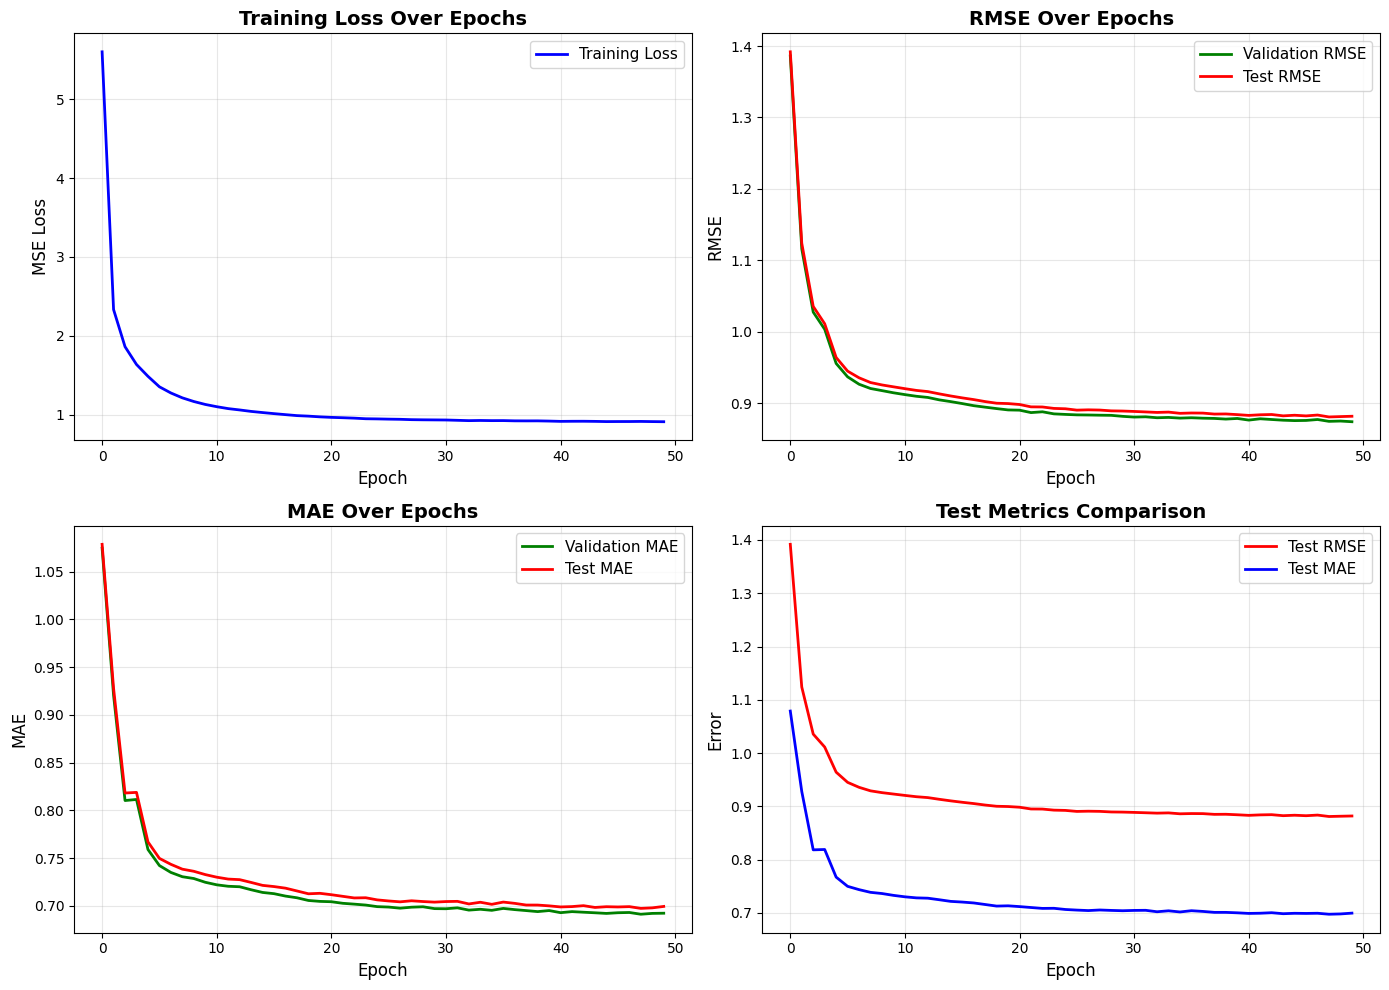

In [12]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(len(train_losses))

# Plot 1: Training Loss
axes[0, 0].plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('MSE Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=11)

# Plot 2: Validation and Test RMSE
axes[0, 1].plot(epochs, val_rmses, 'g-', linewidth=2, label='Validation RMSE')
axes[0, 1].plot(epochs, test_rmses, 'r-', linewidth=2, label='Test RMSE')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('RMSE', fontsize=12)
axes[0, 1].set_title('RMSE Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=11)

# Plot 3: Validation and Test MAE
axes[1, 0].plot(epochs, val_maes, 'g-', linewidth=2, label='Validation MAE')
axes[1, 0].plot(epochs, test_maes, 'r-', linewidth=2, label='Test MAE')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('MAE', fontsize=12)
axes[1, 0].set_title('MAE Over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=11)

# Plot 4: Combined RMSE and MAE (Test)
axes[1, 1].plot(epochs, test_rmses, 'r-', linewidth=2, label='Test RMSE')
axes[1, 1].plot(epochs, test_maes, 'b-', linewidth=2, label='Test MAE')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Error', fontsize=12)
axes[1, 1].set_title('Test Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(fontsize=11)

plt.tight_layout()

# Save figure
models_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
plt.savefig(os.path.join(models_dir, 'autorec_rating_training.png'), dpi=150, bbox_inches='tight')
print(f"✓ Saved training plots to {os.path.join(models_dir, 'autorec_rating_training.png')}")

plt.show()

## Step 11: Sample Predictions

Show how the model reconstructs ratings on sample test instances.

In [13]:
# Get sample predictions
model.eval()

# Sample some test ratings
test_ratings = []
for user in range(test_mat.shape[0]):
    for item in range(test_mat.shape[1]):
        if test_mat[user, item] > 0:
            test_ratings.append((user, item, test_mat[user, item]))

# Sample 15 random test ratings
np.random.seed(42)
sample_indices = np.random.choice(len(test_ratings), size=min(15, len(test_ratings)), replace=False)
sample_ratings = [test_ratings[i] for i in sample_indices]

# Get predictions
train_mat_tensor = torch.FloatTensor(train_set.original_data).to(device)
predictions = []

with torch.no_grad():
    for user, item, actual_rating in sample_ratings:
        # Get item vector from training matrix
        item_vec = train_mat_tensor[:, item].unsqueeze(0).to(device)
        
        # Reconstruct
        reconstructed = model(item_vec)
        reconstructed = torch.clamp(reconstructed, min=1.0, max=5.0)
        
        # Get user's prediction
        pred_rating = reconstructed[0, user].item()
        predictions.append((user, item, actual_rating, pred_rating))

# Display results
print("=" * 80)
print("SAMPLE RATING PREDICTIONS")
print("=" * 80)
print(f"{'User':>6} {'Item':>6} {'Actual':>8} {'Predicted':>10} {'Error':>8}")
print("-" * 80)

for user, item, actual, pred in predictions:
    error = abs(pred - actual)
    print(f"{user:6d} {item:6d} {actual:8.1f} {pred:10.2f} {error:8.2f}")

print("=" * 80)

# Calculate average error
avg_error = np.mean([abs(pred - actual) for _, _, actual, pred in predictions])
print(f"\nAverage Absolute Error on Sample: {avg_error:.4f}")

SAMPLE RATING PREDICTIONS
  User   Item   Actual  Predicted    Error
--------------------------------------------------------------------------------
  1297   1906      3.0       4.16     1.16
  5708   1271      4.0       3.34     0.66
  5885   1468      1.0       2.04     1.04
  1124   1727      4.0       3.07     0.93
  2780   1787      4.0       3.75     0.25
  5366   2733      2.0       2.85     0.85
  3056   2203      5.0       3.84     1.16
  3849     60      4.0       4.10     0.10
   934   3309      4.0       3.84     0.16
  5366    716      1.0       2.34     1.34
  5784    938      3.0       3.08     0.08
   152   3059      5.0       3.42     1.58
  2096    745      4.0       2.87     1.13
  1919   1148      4.0       3.63     0.37
  4466    852      4.0       3.77     0.23

Average Absolute Error on Sample: 0.7360


## Step 11a: Prediction Error Distribution

✓ Saved prediction analysis to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/autorec_rating_predictions.png


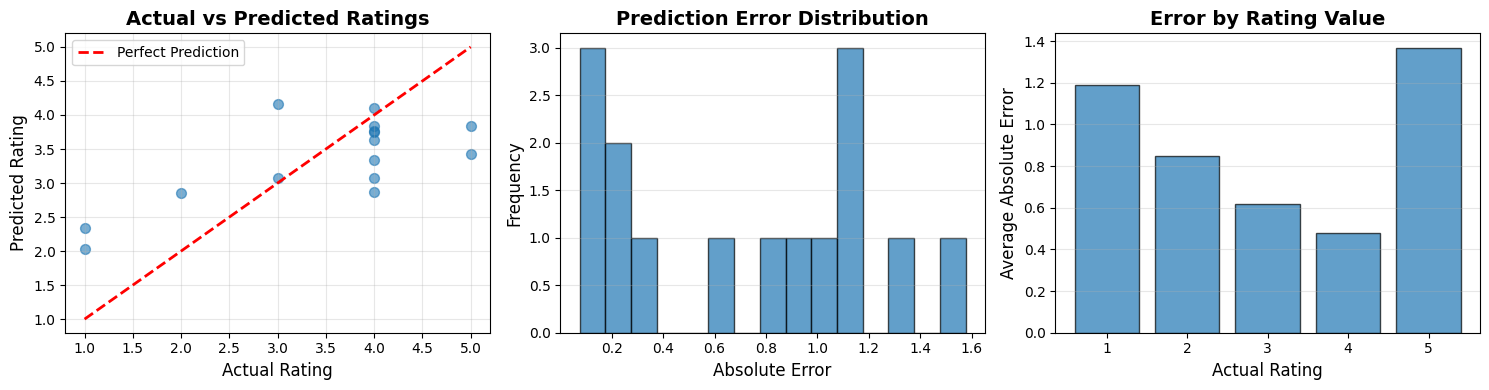

In [14]:
# Visualize prediction errors
if len(predictions) > 0:
    actuals = [actual for _, _, actual, _ in predictions]
    preds = [pred for _, _, _, pred in predictions]
    errors = [abs(pred - actual) for _, _, actual, pred in predictions]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot 1: Actual vs Predicted
    axes[0].scatter(actuals, preds, alpha=0.6, s=50)
    axes[0].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Rating', fontsize=12)
    axes[0].set_ylabel('Predicted Rating', fontsize=12)
    axes[0].set_title('Actual vs Predicted Ratings', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Error Distribution
    axes[1].hist(errors, bins=15, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Absolute Error', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Error by Rating Value
    rating_errors = {}
    for user, item, actual, pred in predictions:
        if actual not in rating_errors:
            rating_errors[actual] = []
        rating_errors[actual].append(abs(pred - actual))
    
    ratings = sorted(rating_errors.keys())
    avg_errors = [np.mean(rating_errors[r]) for r in ratings]
    
    axes[2].bar(ratings, avg_errors, alpha=0.7, edgecolor='black')
    axes[2].set_xlabel('Actual Rating', fontsize=12)
    axes[2].set_ylabel('Average Absolute Error', fontsize=12)
    axes[2].set_title('Error by Rating Value', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Save figure
    models_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
    plt.savefig(os.path.join(models_dir, 'autorec_rating_predictions.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Saved prediction analysis to {os.path.join(models_dir, 'autorec_rating_predictions.png')}")
    
    plt.show()
else:
    print("No predictions available. Please run the sample predictions cell first.")

## Step 12: Train vs Test Metrics Summary

Clarify which metrics are computed on which dataset.

In [15]:
# Evaluate on both train and test sets
print("=" * 70)
print("TRAIN vs TEST METRICS - Final Evaluation")
print("=" * 70)

# Evaluate on training set
train_rmse, train_mae = get_rating_metrics(
    model=model,
    train_set=train_set,
    test_set=train_set,  # Evaluate on training data
    device=device,
    item_based=True
)

# Evaluate on test set
final_test_rmse, final_test_mae = get_rating_metrics(
    model=model,
    train_set=train_set,
    test_set=test_set,
    device=device,
    item_based=True
)

print(f"{'Dataset':<12} | {'RMSE':>12} {'MAE':>12}")
print("-" * 70)
print(f"{'Train':<12} | {train_rmse:>12.4f} {train_mae:>12.4f}")
print(f"{'Test':<12} | {final_test_rmse:>12.4f} {final_test_mae:>12.4f}")
print("=" * 70)
print("\nNote: During training, the printed RMSE/MAE are from the TEST set.")
print("      The 'Loss' value is the training MSE loss.")

TRAIN vs TEST METRICS - Final Evaluation
Dataset      |         RMSE          MAE
----------------------------------------------------------------------
Train        |       0.8278       0.6567
Test         |       0.8818       0.6994

Note: During training, the printed RMSE/MAE are from the TEST set.
      The 'Loss' value is the training MSE loss.


## Step 13: Summary

### Key Results

Results will be displayed in the cell below after training completes.

### Model Architecture

- **Type**: Item-based AutoRec (I-AutoRec)
- **Hidden Units**: 500
- **Loss Function**: MSE with L2 regularization
- **Optimizer**: Adam (lr=0.001)

### Training Details

- **Max Epochs**: 50
- **Early Stopping**: 10 epochs patience
- **Regularization**: λ = 0.001

In [16]:
# Print summary
print("=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation RMSE: {best_val_rmse:.6f}")
print(f"Best Test RMSE: {best_test_rmse:.6f}")
print(f"Best Test MAE: {best_test_mae:.6f}")
print(f"Total Epochs Trained: {len(train_losses)}")
print(f"Regularization (λ): {lambda_reg}")
print("=" * 70)

TRAINING SUMMARY
Best Epoch: 49
Best Validation RMSE: 0.874113
Best Test RMSE: 0.881773
Best Test MAE: 0.699351
Total Epochs Trained: 50
Regularization (λ): 0.001
